In [1]:
from astropy.cosmology import FlatLambdaCDM, Planck15
import matplotlib.pyplot as plt
import numpy as np
import pickle
from time import time

from hmf import MassFunction

from kids_ggl_pipeline.halomodel import nfw as kids_nfw

from plottools.plotutils import update_rcParams
update_rcParams()

# Classes

In [2]:
from __future__ import division

from astropy import constants as ct, units as u
from astropy.cosmology import Planck15
from astropy.units import Quantity
import numpy as np
from numpy.fft import fft, rfft
from scipy.integrate import cumtrapz, dblquad, quad, romb, simps, trapz
from scipy.interpolate import interp1d
from scipy.special import sici
from timeit import timeit

## Decorators and other auxiliary functions

In [3]:
def inMpc(f):
    """Change units of a Quantity to Mpc and return a float.
    
    First argument in `f` must be `R`.
    """
    def decorated(*args, **kwargs):
        if isinstance(args[1], Quantity):
            args[1] = args[1].to(u.Mpc).value
        return f(*args, **kwargs)
    return decorated

def array(f):
    """Turn the first argument (assumed to be `R`) into a 2-d array
    to allow multiple profiles to be defined in one call
    """
    def decorated(*args, **kwargs):
        args = list(args)
#         args[1] = args[1][:,None] if hasattr(args[1], '__iter__') \
#             else np.array([args[1]])[:,None]
        if len(args[1].shape) == 1:
            args[1] = np.expand_dims(args[1], -1)
        return f(*args, **kwargs)
    return decorated

## Cosmology

In [4]:
class BaseCosmo(object):

    def __init__(self, cosmo=Planck15):
        self.cosmo = cosmo
        self._background = None
        self._critical_density = None
        self._hmf = None
        self._mean_density = None
        self._overdensity = None
        self._rho_bg = None
        self.__c = None
        self.__G = None

    @property
    def _c(self):
        if self.__c is None:
            self.__c = ct.c.to(u.Mpc/u.s).value
        return self.__c

    @property
    def _G(self):
        if self.__G is None:
            self.__G = ct.G.to(u.Mpc**3/u.Msun/u.s**2).value
        return self.__G

    @property
    def critical_density(self):
        if self._critical_density is None:
            self._critical_density = \
                self.cosmo.critical_density(self.z).to(u.Msun/u.Mpc**3).value
        return self._critical_density

    @property
    def mean_density(self):
        if self._mean_density is None:
            self._mean_density = \
                (self.cosmo.critical_density0 * self.cosmo.Om0 * (1+self.z)**3).to(
                    u.Msun/u.Mpc**3).value
        return self._mean_density

    @property
    def rho_bg(self):
        if self.background == 'm':
            return self.mean_density
        return self.critical_density


## Lensing

In [5]:
class BaseLensing(BaseCosmo):
    
    def __init__(self, zl, zs=None, cosmo=Planck15):
        """Base lensing calculations

        Note that zs may be an array
        """
        super(BaseLensing, self).__init__(cosmo=cosmo)
        self.zl = zl
        self._zs = zs
        self.cosmo = cosmo
        self._Dl = None
        self._Dls = None
        self._Ds = None
        self.__c = None
        self.__G = None
        # alias
#         self.esd = self.excess_surface_density
        return

    ### attributes ###

    @property
    def zs(self):
        return self._zs

    @zs.setter
    def zs(self, zs):
        self._zs = zs
    
    ### aliases ###

    @property
    def Dl(self):
        if self._Dl is None:
            self._Dl = self.cosmo.angular_diameter_distance(self.zl).to(
                u.Mpc).value
        return self._Dl

    @property
    def Dls(self):
        if self._Dls is None:
            self._Dls = self.cosmo.angular_diameter_distance_z1z2(
                self.zl, self.zs).to(u.Mpc).value
        return self._Dls

    @property
    def Ds(self):
        if self._Ds is None:
            self._Ds = self.cosmo.angular_diameter_distance(self.zs).to(
                u.Mpc).value
        return self._Ds

    ### methods ###

    def beta(self, zs=None):
        if zs is None:
            b = self.Dls/self.Ds
        b = float(self.cosmo.angular_diameter_distance_z1z2(self.zl, zs) \
                  / self.cosmo.angular_diameter_distance(zs))
        return np.max([np.zeros_like(b), b])

    def excess_surface_density(self, R):
        return self.enclosed_surface_density(R) - self.surface_density(R)

    def sigma_crit(self, zs=None):
        """Critical surface density"""
        return self._c**2 / (4*np.pi*self._G) / (self.Dl*self.beta(zs=zs))

    def convergence(self, R, zs=None):
        return self.surface_density(R) / self.sigma_crit(zs=zs)


class Lens(BaseCosmo):
    """Lens object class"""
    # should move some of what's in BaseLensing into here
    # then calling BaseLensing (perhaps just Lensing) should
    # create (or take) both a Lens and a Source objects
    def __init__(self, zl, cosmo=Planck15):
        super(Lens, self).__init__(cosmo=cosmo)
        self.zl = zl
        self._chi = None
        self._Dl = None
        self._Wk = None

    @property
    def chi(self):
        if self._chi is None:
            self._chi = self.cosmo.comoving_distance(self.zl)
        return self._chi
            
    @property
    def Dl(self):
        if self._Ds is None:
            self._Ds = self.cosmo.angular_diameter_distance(self.zl)
        return self._Ds

    ### methods ###

    def Dls(self, zs):
        return self.cosmo.angular_diameter_distance_z1z2(self.zl, zs)

    def sigma_crit(self, zs):
        return self._c**2 / (4*np.pi*self._G) / (self.Dl*self.beta(zs=zs))

    def lensing_kernel(self, zs):
        chizs = self.cosmo.comoving_distance(zs)
        return (3/2 * self.cosmo.Om0 * self.cosmo.H0**2 \
                * (1+zs) / self.cosmo.H(zs) * self.chi / self._c \
                * (chizs-self.chi) / chizs).to(u.Mpc/u.s).value


class Source(BaseCosmo):

    """Lensed source class"""

    def __init__(self, zs, cosmo=Planck15):
        super(Source, self).__init__(cosmo=cosmo)
        self.zs = zs
        self._chi = None
        self._Ds = None
        self._Wk = None

    @property
    def chi(self):
        if self._chi is None:
            self._chi = self.cosmo.comoving_distance(self.zs)
        return self._chi
            
    @property
    def Ds(self):
        if self._Ds is None:
            self._Ds = self.cosmo.angular_diameter_distance(self.zs)
        return self._Ds

    ### methods ###

    def Dls(self, zl):
        return self.cosmo.angular_diameter_distance_z1z2(zl, self.zs)

    def sigma_crit(self, zl):
        return self._c**2 / (4*np.pi*self._G) \
            / (self.angular_diameter_distance(zl)*self.beta(zs=zs))

    def lensing_kernel(self, zl):
        chizl = self.cosmo.comoving_distance(zl)
        return (3/2 * self.cosmo.Om0 * self.cosmo.H0**2 \
                * (1+self.zs) / self.cosmo.H(self.zs) * chizl / self._c \
                * (self.chi-chizl) / self.chi).to(u.Mpc/u.s).value


## Density profiles

Given a 3-dimensional density profile $\rho(r)$, the surface density is
$$
  \Sigma(R) =
      \int_{-\infty}^{+\infty} \, \mathrm{d}r\rho\left(\sqrt{r^2+R^2}\right)
  = 2 \int_0^{+\infty} \, \mathrm{d}r\rho\left(\sqrt{r^2+R^2}\right)
$$
where $R$ is projected distance (on the plane of the sky), and the integrand $r$ runs along the line of sight. Note that for a profile truncated at $r_\mathrm{h}$, the integration limits become $\left\{-\sqrt{r_h^2-R^2},\sqrt{r_h^2-R^2}\right\}$.


The enclosed surface density is then
\begin{align}
 \bar\Sigma(<R) &= \frac
                     {\int_0^R \mathrm{d}r \, r\,\Sigma(r)}{\int_0^R \mathrm{d}r \, r} \\
  &= \frac2{R^2} \, \int_0^R \mathrm{d}r\,r \, \int_{-\infty}^{+\infty} \mathrm{d}t\,\rho\left(\sqrt{t^2+r^2}\right) \\
  &= \frac4{R^2} \, \int_0^R \mathrm{d}r\,r \, \int_0^{+\infty} \mathrm{d}t\,\rho\left(\sqrt{t^2+r^2}\right) \\
\end{align}

In [6]:
class Profile(BaseLensing):

    def __init__(self, mvir, z, cosmo=Planck15,
                 los_loglimit=6, Rlos=200, resampling=20,
                 logleft=-10, left_samples=100):
        """Initialize a profile object

        Should generalize arguments to include pressure profiles
        and other kinds

        Parameters
        ----------
        mvir : float or np.ndarray of floats
            total mass(es) (definition arbitrary)
        z : float or np.ndarray of floats
            redshift(s)
        cosmo : `astropy.cosmology.FLRW` object, optional
            cosmology object

        Optional parameters for numerical integration
        for the (enclosed) surface density (see notes below)
        ----------------------------------------------------
        los_loglimit : int
            log10-limit for the line-of-sight integration
        Rlos : int
            number of samples for the line-of-sight integrals
        resampling : int
            number of samples into which each R-interval in the
            data will be re-sampled. For instance, if two adjacent
            data points are at Rbin=0.1,0.2 then for the integration
            they will be replaced by
                newRbin = np.logspace(np.log10(0.1), np.log10(0.2),
                                      resampling, endpoint=False)
        logleft : int
            log10-starting point for the integration of the enclosed
            surface density. The closer to zero this number the better
        left_samples : int
            number of samples to use between `logleft` and `R[0]`,
            with a logarithmic sampling

        Notes on numerical integration:
        ---
        The values for the integration parameters above have been
        chosen as a compromise between speed and accuracy (<0.5%
        for 0.01<R/Mpc<10) for a gNFW with alpha=1 (i.e., numerical
        integration of an NFW profile). For different profiles you
        may want to tune these differently.

        NOTE: for the benchmarking we need a way to do the integration
        that we know is accurate: should implement a function that uses
        `quad` (which is more accurate but a lot slower than the
        currently used `simps` integration).
        """
        if isinstance(mvir, Quantity):
            mvir = mvir.to(u.Msun).value
        if not np.iterable(mvir):
            mvir = np.array([mvir])
        self.mvir = mvir
        self.z = self._define_array(z)
        super(Profile, self).__init__(z, cosmo=cosmo)
        # for numerical integration -- perhaps these could be passed
        # in a single dictionary
        self.los_loglimit = los_loglimit
        self.Rlos = Rlos
        self.resampling = resampling
        self.logleft = logleft
        self.left_samples = left_samples
        # aliases
        self.barsigma = self.enclosed_surface_density
        self.esd = self.excess_surface_density
        self.sigma = self.surface_density

    @property
    def _one(self):
        if self.__one is None:
            self.__one = u.dimensionless_unscaled
        return self.__one

    ### private methods ###

    def _define_array(self, x):
        if not np.iterable(x):
            return x * np.ones_like(self.mvir)
        return x

    ### methods ###

    @inMpc
    @array
    def surface_density(self, R, single_R=False):
        """Calculate surface density by numerical integration

        `single_R` refers to whether we use a single R array
        to integrate all profiles (assuming more than one were defined).
        If True, it seems both this function and `enclosed_surface_density`
        work to about 10 Mpc within ~0.1% (compared to the analytical NFW)
        but they go wild beyond that, reaching 10% at 100 Mpc for the 
        surface density and 1% for the enclosed surface density.
        
        NOTE: the above seems to be true also for multiple R (which I'm
        not sure I'd expect). More strangely, `single_R=True` now doesn't
        seem to work
        """
        # Need to test single_R=True again. Perhaps it can speed
        # things up a little without giving up much.
        if single_R:
            Rlos = np.logspace(-10, self.los_loglimit, self.Rlos) \
                * self.rvir.max()
            R = np.hypot(*np.meshgrid(Rlos, R[0]))
        else:
            Rlos = np.logspace(-10, self.los_loglimit, self.Rlos)[:,None] \
                * self.rvir
            R = np.transpose(
                [np.hypot(*np.meshgrid(Rlos[:,i], R[:,0]))
                 for i in range(Rlos.shape[1])],
                axes=(1,2,0))
        return 2 * simps(self.density(R), Rlos[None], axis=1)

    @inMpc
    @array
    def enclosed_surface_density(self, R):
        logR = np.log10(R)
        # resample R
        Ro = np.vstack([
            np.zeros(R.shape[1]),
            np.logspace(-10, logR[0], self.left_samples, endpoint=False)[:,None],
            np.concatenate(
                [np.logspace(logR[i-1], logR[i], self.resampling, endpoint=False)
                 for i in range(1, R.shape[0])])[:,None],
            R.max()*np.ones(R.shape[1])
            ])
        j = np.arange(1+self.left_samples, Ro.shape[0], self.resampling)
        integ = cumtrapz(Ro*self.surface_density(Ro),
                         Ro, initial=0, axis=0)
        return 2 * integ[j] / R**2

    def excess_surface_density(self, R):
        """Excess surface density at projected distance(s) R

        The excess surface density or ESD is the lensing observable
        in physical units, and is calculated as:
            ESD(R) = Sigma(<R) - Sigma(R)
        where Sigma(<R) is the average surface density within R and
        Sigma(R) is the surface density at distance R

        Parameters
        ----------
        R : float or array of float
            projected distance(s)
        kwargs : dict, optional
            passed to both `self.enclosed_surface_density` and
            `self.surface_density`
        """
        return self.enclosed_surface_density(R) \
            - self.surface_density(R)

    def fourier(self, rmax=10, dr=0.1):
        r = np.arange(dr, rmax, dr)
        f = self.density(r)
        # compute Fourier transform by numpy's FFT function
        g = fft(f)
        print('g =', g.shape)
        # frequency normalization factor is 2*np.pi/dt
        k = np.fft.fftfreq(f.size)*2*np.pi/dr
        # in order to get a discretisation of the continuous
        # Fourier transform we need to multiply g by a phase factor
        g = g * dr * np.exp(1j*k[:,None]*rmax) / (2*np.pi)**0.5
        return k, g

    def fourier1(self, R, k, n=10000, **kwargs):
        def DFT_slow(x, k=None):
            """Compute the discrete Fourier Transform of the 1D array x"""
            x = np.asarray(x, dtype=float)
            N = x.shape[0]
            n = np.arange(N)
#             k = n.reshape((N, 1))
#             k = np.logspace(-20, 20, N)[:,np.newaxis]
            if k is None:
                k = n
            M = np.exp(-2j * np.pi * k[:,np.newaxis] * x / N)
            print(n.shape, k.shape, M.shape)
            return np.dot(M, x)
        R = np.logspace(np.log10(R.min()), np.log10(R.max()), k.size)
        R = np.logspace(-10, np.log10(self.rvir), k.size)
        k = np.linspace(-3, 3, R.size)
        print('R =', R.shape)
        print('k =', k.shape)
        d = DFT_slow(self.density(R), k)
        print('d =', d.shape)
        return d / d[0]
#         x = np.logspace(-10, 10, n)*self.rvir
#         print('x =', x.shape)
        uk = fft(self.density(R), **kwargs)
        return uk / uk[0]

    ### auxiliary methods to test integration performance ###

    @inMpc
    @array
    def quad_surface_density(self, R):
        integrand = lambda r, Ro: self.density((r**2+Ro**2)**0.5)
        return np.array([[quad(integrand, 0, np.inf, args=(Rij,))
                          for Rij in Ri] for Ri in R])

    @inMpc
    @array
    def test_integration(self, R, output=None):
        """Test the fast-integration methods against the slow
        but accurate quad function
        """
#         fig, axes = plt.subplots
        qsd = self.quad_surface_density(R)
        sd = self.surface_density(R)
        


class BaseNFW(Profile):

    def __init__(self, mvir, c, z, overdensity=200, background='c', cosmo=Planck15):
        assert background in 'cm', \
            "background must be either 'c' (critical) or 'm' (mean)"
        super(BaseNFW, self).__init__(mvir, z, cosmo=cosmo)
        self._background = background
        self._concentration = self._define_array(c)
        self._overdensity = overdensity
        self._deltac = None
        self._rs = None
        self._rvir = None
        self._sigma_s = None

    ### attributes ###

    @property
    def background(self):
        return self._background

    @property
    def c(self):
        return self._concentration

    @property
    def deltac(self):
        if self._deltac is None:
            self._deltac = (self.overdensity * self.c**3 / 3) \
                / (np.log(1+self.c) - self.c/(1+self.c))
        return self._deltac

    @property
    def overdensity(self):
        return self._overdensity

    @property
    def rs(self):
        if self._rs is None:
            self._rs = self.rvir / self.c
        return self._rs

    @property
    def rvir(self):
        if self._rvir is None:
            self._rvir = \
                (self.mvir / (4*np.pi/3) / (self.overdensity*self.rho_bg))**(1/3)
        return self._rvir

    @property
    def sigma_s(self):
        if self._sigma_s is None:
            self._sigma_s = self.rs * self.deltac * self.rho_bg
        return self._sigma_s


class gNFW(BaseNFW):

    def __init__(self, mvir, c, alpha, z, **kwargs):
        super(gNFW, self).__init__(mvir, c, z, **kwargs)
        self.alpha = self._define_array(alpha)

    ### main methods ###

    @inMpc
    @array
    def density(self, R):
        return self.deltac * self.rho_bg \
            / ((R/self.rs)**self.alpha * (1+R/self.rs)**(3-self.alpha))


class NFW(BaseNFW):
    """Navarro-Frenk-White profile
    
    does not yet handle conversion from one overdensity to another
    """
    
    def __init__(self, mvir, c, z, **kwargs):
        super(NFW, self).__init__(mvir, c, z, **kwargs)

    ### main methods ###

    @inMpc
    @array
    def density(self, R):
        return self.deltac * self.rho_bg / (R/self.rs * (1+R/self.rs)**2)

    @inMpc
    @array
    def surface_density(self, R):
        """Surface density at distance(s) R"""
        x = R / self.rs
        s = np.ones_like(x) / 3
        s[x == 0] = 0
        j = (x > 0) & (x < 1)
        s[j] = (1 - 2*np.arctanh(((1-x[j]) / (1+x[j]))**0.5) / (1 - x[j]**2)**0.5) \
            / (x[j]**2 - 1)
        j = x > 1
        s[j] = (1 - 2*np.arctan(((x[j]-1) / (1+x[j]))**0.5) / (x[j]**2 - 1)**0.5) \
            / (x[j]**2 - 1)
        return 2 * self.sigma_s * s

    @inMpc
    @array
    def enclosed_surface_density(self, R):
        """Surface density enclosed within R"""
        x = R / self.rs
        s = np.ones_like(x) + np.log(0.5)
        s[x == 0] = 0
        j = (x > 0) & (x < 1)
        s[j] = (np.log(0.5*x[j]) \
                + 2 * np.arctanh(((1 - x[j])/(1 + x[j]))**0.5) \
                  / (1 - x[j]**2)**0.5) \
               / x[j]**2
        j = x > 1
        s[j] = (2 * np.arctan(((x[j] - 1)/(1 + x[j]))**0.5) / (x[j]**2-1)**0.5 \
                + np.log(0.5*x[j])) / x[j]**2
        return 4 * self.sigma_s * s

    @array
    def fourier(self, k):
        ki = k * self.rs
        bs, bc = sici(ki)
        asi, ac = sici((1+self.c)*ki)
        return 4 * np.pi * self.rho_bg * self.deltac * self.rs**3 / self.mvir \
            * (np.sin(ki)*(asi-bs) - (np.sin(self.c*ki) / ((1+self.c)*ki)) \
               + np.cos(ki)*(ac-bc))


class tNFW5(BaseNFW):

    def __init__(self, mvir, c, rt, z, **kwargs):
        super(NFW, self).__init__(mvir, c, z, **kwargs)
        self.rt = rt

    ### methods ###

    @inMpc
    def density(self, R):
        return

    ### auxiliary methods ###

    @inMpc
    def F(self, R):
        x = R / self.rs
        f = np.ones_like(x)
        f[x < 1] = np.log(1/x[x<1] + (1/x[x<1]**2 - 1)**0.5) \
            / (1 - x[x<1]**2)**0.5
        f[x > 1] = np.arccos(1/x[x>1]) / (x[x>1]**2 - 1)**0.5
        return f


### Test multiple NFWs in one call

In [7]:
R = np.logspace(-2, 1, 12)
# R = np.logspace(-2, 1, 10)

mvirs = 10**np.arange(5, 16, 2)
# mvirs = np.array([1e14])
cs = np.ones_like(mvirs) * 5
zs = 0.5
alphas = 1

g = (99, 1)


/Users/cristobal/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(array([  0.        ,   0.63466518,   1.26933037,   1.90399555,
          2.53866073,   3.17332591,   3.8079911 ,   4.44265628,
          5.07732146,   5.71198664,   6.34665183,   6.98131701,
          7.61598219,   8.25064737,   8.88531256,   9.51997774,
         10.15464292,  10.7893081 ,  11.42397329,  12.05863847,
         12.69330365,  13.32796883,  13.96263402,  14.5972992 ,
         15.23196438,  15.86662956,  16.50129475,  17.13595993,
         17.77062511,  18.40529029,  19.03995548,  19.67462066,
         20.30928584,  20.94395102,  21.57861621,  22.21328139,
         22.84794657,  23.48261175,  24.11727694,  24.75194212,
         25.3866073 ,  26.02127248,  26.65593767,  27.29060285,
         27.92526803,  28.55993321,  29.1945984 ,  29.82926358,
         30.46392876,  31.09859394, -31.09859394, -30.46392876,
        -29.82926358, -29.1945984 , -28.55993321, -27.92526803,
        -27.29060285, -26.65593767, -26.02127248, -25.3866073 ,
        -24.75194212, -24.11727694, -23.

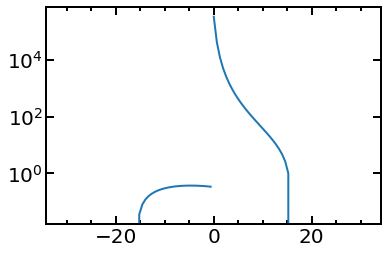

In [8]:
gnfw = gNFW(mvirs[0], cs[0], alphas, zs)
k, g = gnfw.fourier()
plt.semilogy(k, g)
k, k.shape, g.shape

In [9]:
%timeit NFW(mvirs, cs, zs)
%timeit gNFW(mvirs, cs, alphas, zs)
nfws = NFW(mvirs, cs, zs)
gnfws = gNFW(mvirs, cs, alphas, zs)
print('Using:')
print('los_loglimit =', gnfws.los_loglimit)
# print('Rlos =', gnfws.Rlos)
print('resampling =', gnfws.resampling)
print('logleft =', gnfws.logleft)
print('left_samples =', gnfws.left_samples)

10.5 µs ± 221 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
14.9 µs ± 336 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
Using:
los_loglimit = 6
resampling = 20
logleft = -10
left_samples = 100


In [10]:
x = nfws.density(R)
print('density:', x.shape)
y = nfws.surface_density(R)
print('surface density:', y.shape)
z = nfws.esd(R)
print('esd:', z.shape)
print('NFWs passed!')

x = gnfws.density(R)
print('density:', x.shape)
y = gnfws.surface_density(R)
print('surface density:', y.shape)
z = gnfws.esd(R)
print('esd:', z.shape)
print('gNFWs passed!')

density: (12, 6)
surface density: (12, 6)
esd: (12, 6)
NFWs passed!
density: (12, 6)
surface density: (12, 6)
esd: (12, 6)
gNFWs passed!


In [11]:
def create_nfw():
    nfws = NFW(mvirs, cs, zs)
    return nfws.esd(R)

def create_gnfw():
    gnfws = gNFW(mvirs, cs, alphas, zs)
    return gnfws.esd(R)

%timeit create_nfw()
%timeit create_gnfw()

378 µs ± 23.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
38 ms ± 9.77 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
sd_nfw = nfws.surface_density(R)
sd = gnfws.surface_density(R)
encsd_nfw = nfws.enclosed_surface_density(R)
encsd = gnfws.enclosed_surface_density(R)
esd_nfw = nfws.esd(R)
esd = gnfws.esd(R)
print('NFWs:')
%timeit nfws.surface_density(R)
%timeit nfws.enclosed_surface_density(R)
%timeit nfws.esd(R)
print('gNFWs:')
%timeit gnfws.surface_density(R)
%timeit gnfws.enclosed_surface_density(R)
%timeit gnfws.esd(R)

NFWs:
58.3 µs ± 4.71 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
79.1 µs ± 17.8 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
162 µs ± 45.3 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
gNFWs:
1.88 ms ± 219 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
27.9 ms ± 2.16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
30.9 ms ± 1.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
# %prun -l 5 gnfws.enclosed_surface_density(R, Rp=Rp, sampling=sampling)
# %timeit gnfws.surface_density(R)

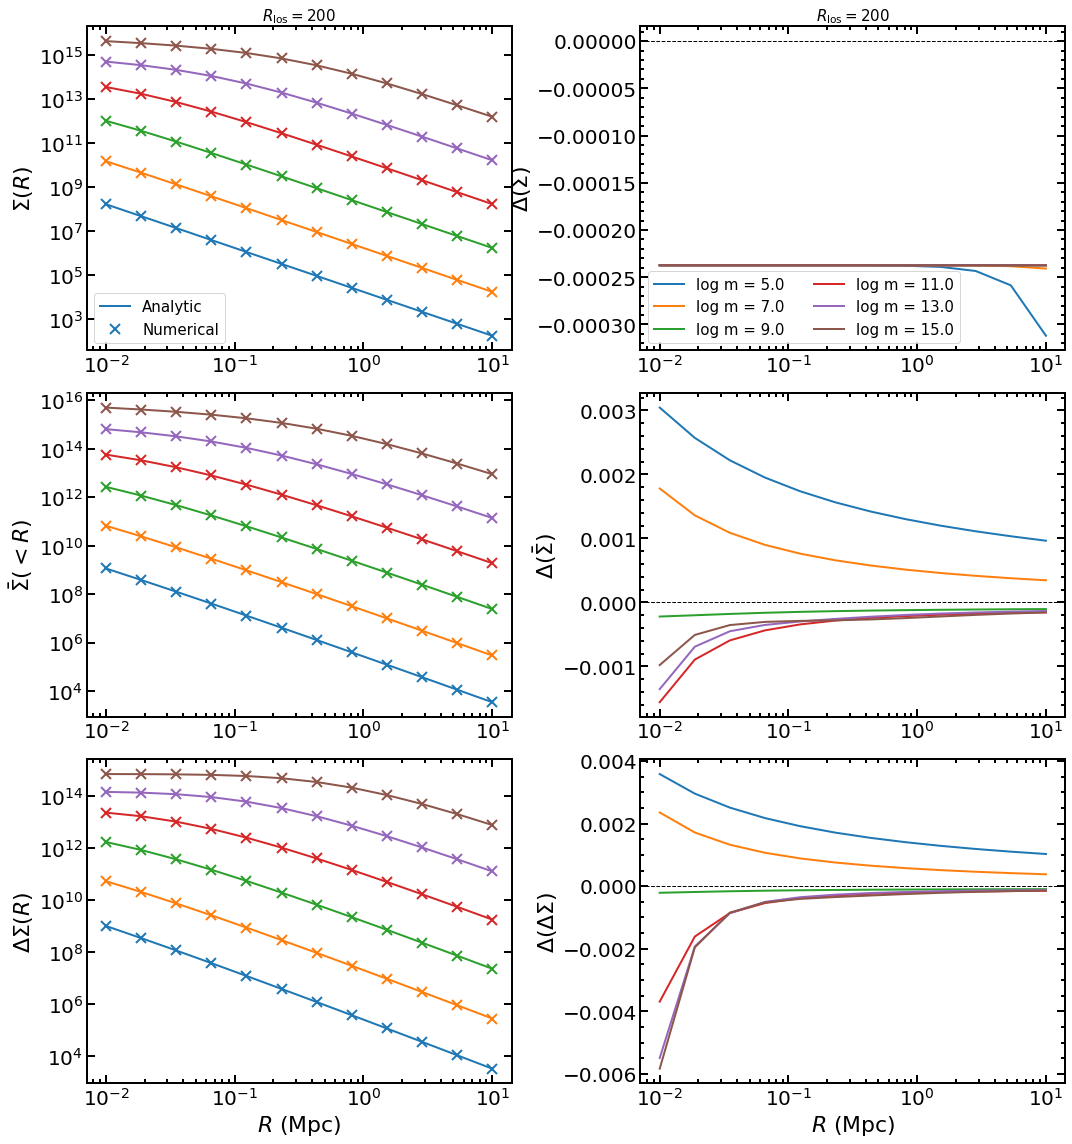

In [16]:
jm = 0

fig, axes = plt.subplots(figsize=(15,16), ncols=2, nrows=3)
axes = np.reshape(axes, -1)
for ax in axes:
    ax.set_xscale('log')
for ax in axes[::2]:
    ax.set_yscale('log')
for ax in axes[1::2]:
    ax.axhline(0, ls='--', color='k', lw=1)
axes[0].set_ylabel(r'$\Sigma(R)$')
axes[1].set_ylabel(r'$\Delta(\Sigma)$')
axes[2].set_ylabel(r'$\bar\Sigma(<R)$')
axes[3].set_ylabel(r'$\Delta(\bar\Sigma)$')
axes[4].set_ylabel(r'$\Delta\Sigma(R)$')
axes[5].set_ylabel(r'$\Delta(\Delta\Sigma)$')
for ax in axes[-2:]:
    ax.set_xlabel('$R$ (Mpc)')
for ax in axes[:2]:
    ax.set_title(r'$R_\mathrm{{los}} = {0}$'.format(nfws.Rlos), fontsize=15)

# Surface density
for i in range(sd.shape[1]):
    color = 'C{0}'.format(i)
    axes[0].plot(R, sd_nfw[:,i], '-', color=color,
                 label='Analytic' if i == 0 else '_none_')
    axes[0].plot(R, sd[:,i], 'x', color=color, mew=2, ms=10,
                 label='Numerical' if i == 0 else '_none_')
    axes[1].plot(R, sd[:,i]/sd_nfw[:,i]-1, ls='-', color=color,
                 label='log m = {0:.1f}'.format(np.log10(mvirs[i])))
axes[0].legend(fontsize=15)
axes[1].legend(fontsize=15, ncol=2)

# Enclosed surface density
for i in range(encsd.shape[1]):
    color = 'C{0}'.format(i)
    axes[2].plot(R, encsd_nfw[:,i], '-', color=color)
    axes[2].plot(R, encsd[:,i], 'x', color=color, mew=2, ms=10)
    axes[3].plot(R, encsd[:,i]/encsd_nfw[:,i]-1, color=color)

# Excess surface density
for i in range(esd.shape[1]):
    color = 'C{0}'.format(i)
    axes[4].plot(R, esd_nfw[:,i], '-', color=color)
    axes[4].plot(R, esd[:,i], 'x', color=color, mew=2, ms=10)
    axes[5].plot(R, esd[:,i]/esd_nfw[:,i]-1, color=color)

fig.tight_layout()

(2048,) (2048, 1) (2048, 2048) (2048, 1)
(2048,) (2048, 1) (2048, 2048) (2048, 1)
(2048, 1) (2048, 1)


/Users/cristobal/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


False

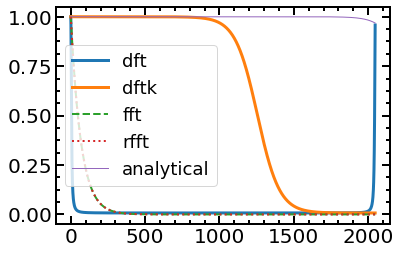

In [24]:
def DFT_slow(x, k=None):
    """Compute the discrete Fourier Transform of the 1D array x"""
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
#     n = np.arange(N)
#     k = n.reshape((N, 1))
    n = np.arange(N)
    if k is None:
        k = np.arange(x.shape[0])[:,None]
#     k = np
    M = np.exp(-2j * np.pi * k * n / N).T
    print(n.shape, k.shape, M.shape, x.shape)
    return np.dot(M.T, x)

nfw = NFW(mvirs[0], cs[0], zs)
# x = np.random.random(100)
x = np.logspace(-10, 3, 2048)
# x = np.linspace(1, 10, 2048)
x = nfw.density(x)
k = np.logspace(-3, 3, x.size)[:,None]
kx = k.reshape(-1)
dft = DFT_slow(x)
dftk = DFT_slow(x, k)
f = fft(x)
rf = rfft(x)
plt.plot(dft/dft[0], lw=3, label='dft')
plt.plot(dftk/dftk[0], ls='-', lw=3, label='dftk')
plt.plot(f/f[0], ls='--', lw=2, label='fft')
plt.plot(rf/rf[0], ls=':', lw=2, label='rfft')
plt.plot(nfw.fourier(k), ls='-', lw=1, label='analytical')
# plt.xscale('log')
# plt.yscale('log')
plt.legend()
print(dft.shape, f.shape)
np.allclose(dft, f)

In [32]:
import matplotlib.pyplot as plt

R = np.logspace(-2, 1, 100)

z = 0.5
mvir = 1e15
c = 4
alpha = 1

nfw = NFW(mvir, c, z)
gnfw = gNFW(mvir, c, alpha, z)
esd_kids = 1e12 * kids_nfw.esd(R/nfw.rs, nfw.sigma_s)

# if this works I should see nothing in the output
x = pickle.dumps(nfw.esd)

# %timeit gnfw.surface_density(R)
# x = gnfw.esd(R)

In [33]:
k = np.logspace(-3, 3, 512)

uk_kids = kids_nfw.uk(k, np.array([mvir]), np.array([nfw.rvir]), np.array([c]), z, nfw.rho_bg)[:,0]
print(uk_kids.shape)
f = gnfw.fourier(R, k)#, n=k.size)
print('f =', f.shape)
# print(f)

fig, axes = plt.subplots(figsize=(16,5), ncols=2)
for ax in axes:
    ax.set_xscale('log')
    ax.set_xlabel('$k$ (Mpc$^{-1}$)')
ax = axes[0]
ax.set_yscale('log')
ax.set_ylabel('$u_k$')
ax.plot(k, uk_kids);
ax.plot(k, nfw.fourier(k), '--')
ax.plot(k, f, 'x')
ax = axes[1]
ax.set_ylabel('ratio')
ax.plot(k, (nfw.fourier(k)/uk_kids))
ax.axhline(1, ls='--', lw=1)
ax.set_ylim(0.999, 1.001)
fig.tight_layout()
((f > 0) & np.isfinite(f)).sum(), f.size

(512,)


ValueError: operands could not be broadcast together with shapes (100,) (512,) 

### What does the gNFW look like?

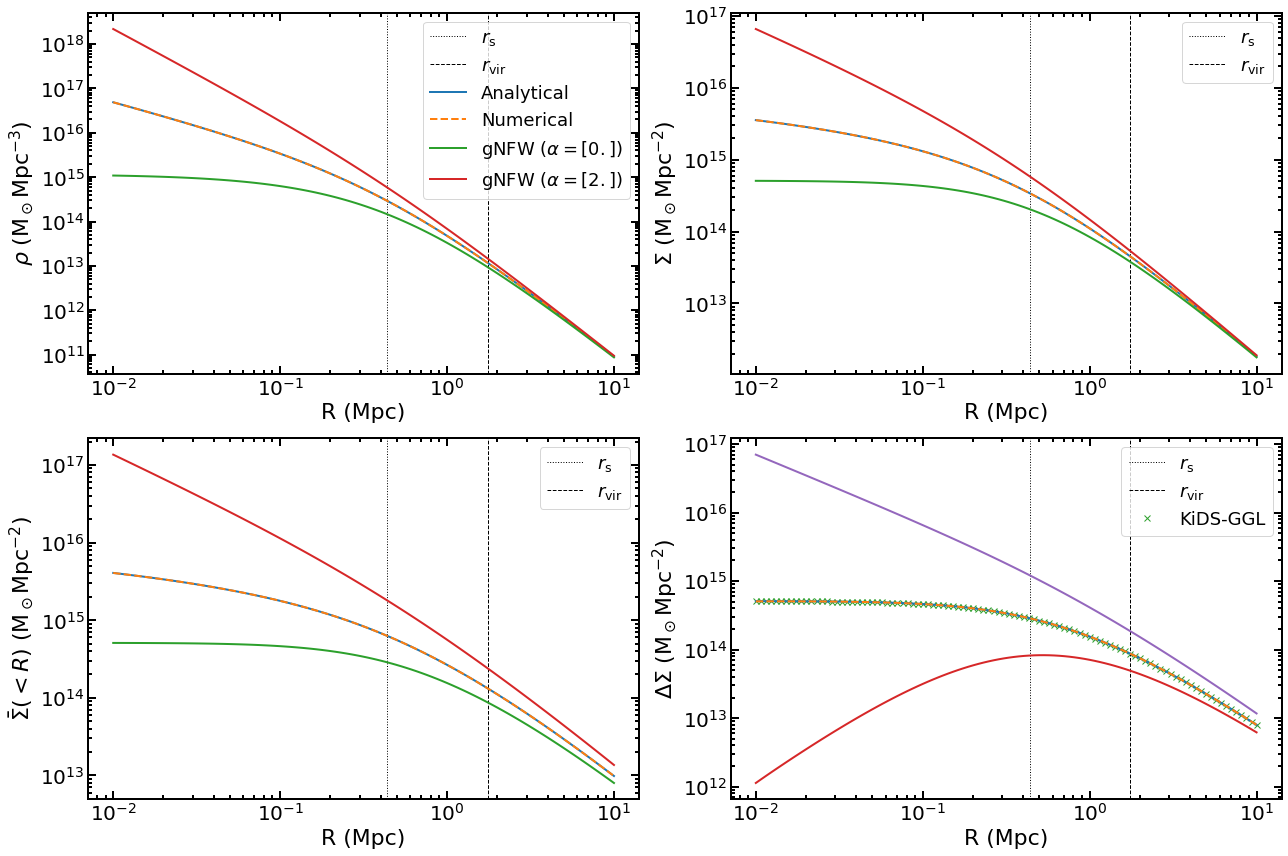

In [34]:
rho = nfw.density(R)
zs = 1.0
kappa = nfw.convergence(R, zs=zs)
kappa_cmb = nfw.convergence(R, zs=1100)

fig, axes = plt.subplots(figsize=(18,12), ncols=2, nrows=2)
# fig, axes = plt.subplots(figsize=(18,6), ncols=2)
axes = np.reshape(axes, -1)
for ax in axes:
    ax.axvline(nfw.rs, ls=':', lw=1, color='k', label='$r_\mathrm{s}$')
    ax.axvline(nfw.rvir, ls='--', lw=1, color='k', label='$r_\mathrm{vir}$')
    ax.set_xlabel('R (Mpc)')
    ax.set_xscale('log')
    ax.set_yscale('log')

gnfw_alt = [gNFW(mvir, c, alpha, z) for alpha in (0, 2)]

ax = axes[0]
ax.plot(R, rho, label='Analytical')
ax.plot(R, gnfw.density(R), '--', label='Numerical')
for g in gnfw_alt:
    ax.plot(R, g.density(R), '-', label=r'gNFW ($\alpha={0}$)'.format(g.alpha))
ax.set_ylabel(r'$\rho$ (M$_\odot$Mpc$^{-3}$)')
ax = axes[1]
ax.plot(R, nfw.surface_density(R))
ax.plot(R, gnfw.surface_density(R), '--')
for g in gnfw_alt:
    ax.plot(R, g.surface_density(R), '-')
ax.set_ylabel(r'$\Sigma$ (M$_\odot$Mpc$^{-2}$)')
ax = axes[2]
# ax.plot(R, kappa, label=r'$z_\mathrm{{s}}={0:.1f}$'.format(zs))
# ax.plot(R, kappa_cmb, label='CMB')
# ax.set_ylabel(r'Convergence $\kappa$')
ax.plot(R, nfw.enclosed_surface_density(R))
ax.plot(R, gnfw.enclosed_surface_density(R), '--')
for g in gnfw_alt:
    ax.plot(R, g.enclosed_surface_density(R), '-')
ax.set_ylabel(r'$\bar\Sigma(<R)$ (M$_\odot$Mpc$^{-2}$)')
ax = axes[3]
ax.plot(R, nfw.esd(R))
ax.plot(R, gnfw.esd(R), '--')
ax.plot(R, esd_kids, 'x', zorder=-1, label='KiDS-GGL')
for g in gnfw_alt:
    ax.plot(R, g.esd(R), '-')
ax.set_ylabel(r'$\Delta\Sigma$ (M$_\odot$Mpc$^{-2}$)')

for ax in axes:
    ax.legend()
fig.tight_layout()

### Performance with number of data points

In [ ]:
n = np.arange(10, 101, 10, dtype=int)
t = []
terr = []
for i in n:
    R = np.logspace(-2, 1, i)
    ti = %timeit -o gnfw.esd(R)
    t.append(ti.average)
    terr.append(ti.stdev)

In [ ]:
fig, ax = plt.subplots()
ax.errorbar(n, t, terr)
ax.plot(n, (n/7e3)**0.8, label='$y\propto x^{0.8}$')
ax.legend()
ax.set_xlabel('Number of data points')
ax.set_ylabel('time (s)')
ax.set_yscale('log')

# Lenses and Sources

Text(0, 0.5, 'CMB Lensing kernel')

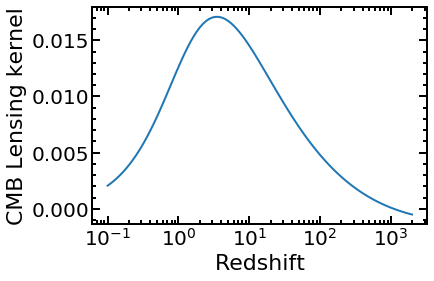

In [35]:
cmb = Source(1100)
zx = np.logspace(-1, 3.3, 100)
Wk = cmb.lensing_kernel(zx)
plt.semilogx(zx, Wk)
plt.xlabel('Redshift')
plt.ylabel('CMB Lensing kernel')

Text(0, 0.5, 'Lensing kernel, $z_\\mathrm{l}=0.5$')

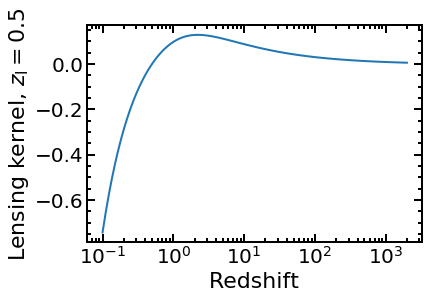

In [36]:
cl = Lens(0.5)
Wcl = cl.lensing_kernel(zx)
plt.semilogx(zx, Wcl)
plt.xlabel('Redshift')
plt.ylabel(r'Lensing kernel, $z_\mathrm{{l}}={0:.1f}$'.format(cl.zl))

Text(0, 0.5, '$W^\\kappa(z_\\mathrm{lens})$')

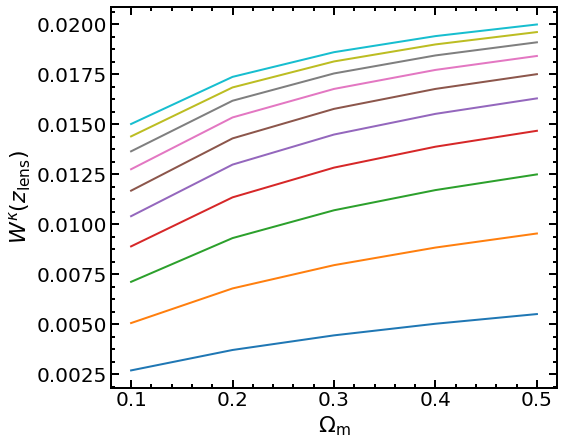

In [37]:
fig, ax = plt.subplots(figsize=(8,7))
Om = np.arange(0.1, 0.51, 0.1)
for zl in np.arange(0.2, 2.01, 0.2):
    Wk = np.zeros(Om.size)
    for i, Om0 in enumerate(Om):
        cosmo = FlatLambdaCDM(70, Om0, 1-Om0)
        cmb = Source(1100, cosmo=cosmo)
        Wk[i] = cmb.lensing_kernel(zl)
    ax.plot(Om, Wk, label=r'$z_\mathrm{{lens}}={0:.1f}$'.format(zl))
ax.set_xlabel(r'$\Omega_\mathrm{m}$')
ax.set_ylabel(r'$W^\kappa(z_\mathrm{lens})$')

# Fourier transform

In [41]:
'''
Created on Oct 12, 2009
@author: Adam Laiacano
'''
import numpy

def nextpow2(num):
    '''
    Returns the next highest power of 2 from the given value.
    Example
    -------
    >>>nextpow2(1000)
    1024
    >>nextpow2(1024)
    2048
    '''
    npow = 2
    while npow <= num: 
        npow = npow * 2
    return npow



class FrFFT(object):
    '''
    Computes the fractional fast Fourier transform of a given input.  
    
    FrFFT(x, alpha)
    
    USAGE:
    
    import frfft
    from numpy import linspace, pi, sin
    t=linspace(-4*pi,4*pi, 1000)
    x=sin(2*pi*40*t) + sin(2*pi*20*t) + sin(2*pi*10*t)
    X=frfft.FrFFT(x,1./1024)
    subplot(211)
    plot(numpy.abs(X.result))
    subplot(212)
    plot(numpy.unwrap(arctan2(X.result.imag,X.result.real)))
    show()
    
    '''


    def __init__(self, x_in, alpha):
        '''
        Sets up required variables and computes FrFFT.
        
        @param x Input sequence
        @param alpha Fractional FFT value.
        '''
        
        ## M = length of the input vector
        self.m_in = len(x_in)
        
        ## Alpha value
        self.alpha = float(alpha * 1.)
        
        ## pp >= 2*m+1
        self.p_p = nextpow2(self.m_in + 1)
        
        ## Complex valued input data
        self.data = numpy.array(x_in, dtype = 'complex')
        
        ## Output place holder
        self.result = numpy.zeros(self.m_in, dtype = 'complex')
        
        # Run the process
        self.replace_alpha(1. * alpha)
        
        
        
    def replace_alpha(self, alpha):
        '''
        Resets the alpha value and re-runs the FrFFT.
        
        '''
        self.alpha = float(alpha)
        
        # take 2p-point FFTs of y and z
        fft_y = numpy.fft.fft(self.__generate_y(), self.p_p)
        
        fft_z = numpy.fft.fft(self.__generate_z(), self.p_p)
        
        j_g = numpy.arange(0, self.m_in, dtype = 'float')
        exponent = -1j * numpy.pi * j_g**2 * self.alpha
        y_z = numpy.fft.ifft(fft_y * fft_z, self.p_p)
        self.result = numpy.exp(exponent) * y_z[:self.m_in]
        
        
    def __generate_y(self):
        '''
        Intermediary function to calculate y described above.
        '''
        y_out = numpy.zeros(self.p_p, dtype = 'complex')
        
        j_y = numpy.arange(0, self.m_in, dtype = 'float')
        
        exponent = -1j * numpy.pi * j_y**2 * self.alpha
        
        y_out[:self.m_in] = self.data * numpy.exp(exponent)
        return y_out
    
    def __generate_z(self):
        
        '''
        Intermediary function to calculate z described above.
        '''
        z_out = numpy.zeros(self.p_p, dtype = 'complex')
        
        j_z = numpy.arange(0, self.p_p, dtype = 'float')
        pp_m = self.p_p - self.m_in        
        
        exponent = 1j * numpy.pi * j_z[:self.m_in]**2 * self.alpha
        z_out[:self.m_in] = numpy.exp(exponent)
        z_out[pp_m:] = numpy.exp(numpy.pi * j_z[pp_m:]**2 * self.alpha * 1j)

        return z_out

/Users/cristobal/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


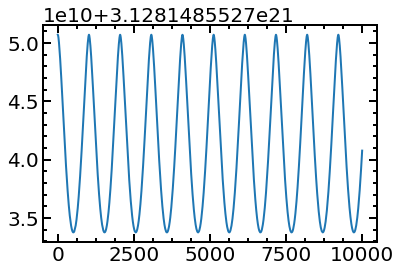

In [46]:
R = np.linspace(1e-10, 100, 10000)
rho = nfws.density(R)[:,0]
uk = FrFFT(rho, 1/1024)
plt.plot(uk.result)

In [ ]:
from mpmath import mp
mp.dps = 50
mpquad = mp.quad

f = lambda x: np.exp(-1j*x) / (x*(1+x)**2)

%timeit mpquad(lambda x: mp.exp(-1j*x) / (x*(1+x)**2), [0, mp.inf])**2
%timeit quad(lambda x: np.exp(-1j*x) / (x*(1+x)**2), 0, np.inf)[0]**2
# %timeit simps()